## Import Libraries
---

In [47]:
from collections import Counter
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

## Reading Data
---

I devided the input data into 4 classes of variables as the data descriptions (categorical, continuous, discrete, dummy), because manners of preprocessing are different.

In [48]:
# read data
TRAIN_DATA = pd.read_csv("train.csv")
TEST_DATA = pd.read_csv("test.csv")

CATEGORICAL_COLUMNS = ["Product_Info_1", "Product_Info_2", "Product_Info_3", "Product_Info_5", "Product_Info_6",\
                       "Product_Info_7", "Employment_Info_2", "Employment_Info_3", "Employment_Info_5", "InsuredInfo_1",\
                       "InsuredInfo_2", "InsuredInfo_3", "InsuredInfo_4", "InsuredInfo_5", "InsuredInfo_6", "InsuredInfo_7",\
                       "Insurance_History_1", "Insurance_History_2", "Insurance_History_3", "Insurance_History_4", "Insurance_History_7",\
                       "Insurance_History_8", "Insurance_History_9", "Family_Hist_1", "Medical_History_2", "Medical_History_3",\
                       "Medical_History_4", "Medical_History_5", "Medical_History_6", "Medical_History_7", "Medical_History_8",\
                       "Medical_History_9", "Medical_History_11", "Medical_History_12", "Medical_History_13", "Medical_History_14",\
                       "Medical_History_16", "Medical_History_17", "Medical_History_18", "Medical_History_19", "Medical_History_20",\
                       "Medical_History_21", "Medical_History_22", "Medical_History_23", "Medical_History_25", "Medical_History_26",\
                       "Medical_History_27", "Medical_History_28", "Medical_History_29", "Medical_History_30", "Medical_History_31",\
                       "Medical_History_33", "Medical_History_34", "Medical_History_35", "Medical_History_36", "Medical_History_37",\
                       "Medical_History_38", "Medical_History_39", "Medical_History_40", "Medical_History_41"]
CONTINUOUS_COLUMNS = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI",
                      "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                      "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
DISCRETE_COLUMNS = ["Medical_History_1", "Medical_History_10", "Medical_History_15", "Medical_History_24", "Medical_History_32"]
DUMMY_COLUMNS = ["Medical_Keyword_{}".format(i) for i in range(1, 48)]

categorical_data = pd.concat([TRAIN_DATA[CATEGORICAL_COLUMNS], TEST_DATA[CATEGORICAL_COLUMNS]])
continuous_data = pd.concat([TRAIN_DATA[CONTINUOUS_COLUMNS], TEST_DATA[CONTINUOUS_COLUMNS]])
discrete_data = pd.concat([TRAIN_DATA[DISCRETE_COLUMNS], TEST_DATA[DISCRETE_COLUMNS]])
dummy_data = pd.concat([TRAIN_DATA[DUMMY_COLUMNS], TEST_DATA[DUMMY_COLUMNS]])

## Preprocessing Data
---

### Categorical Data
---
The following 60 columns of 128 columns represent categorical data:  

Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

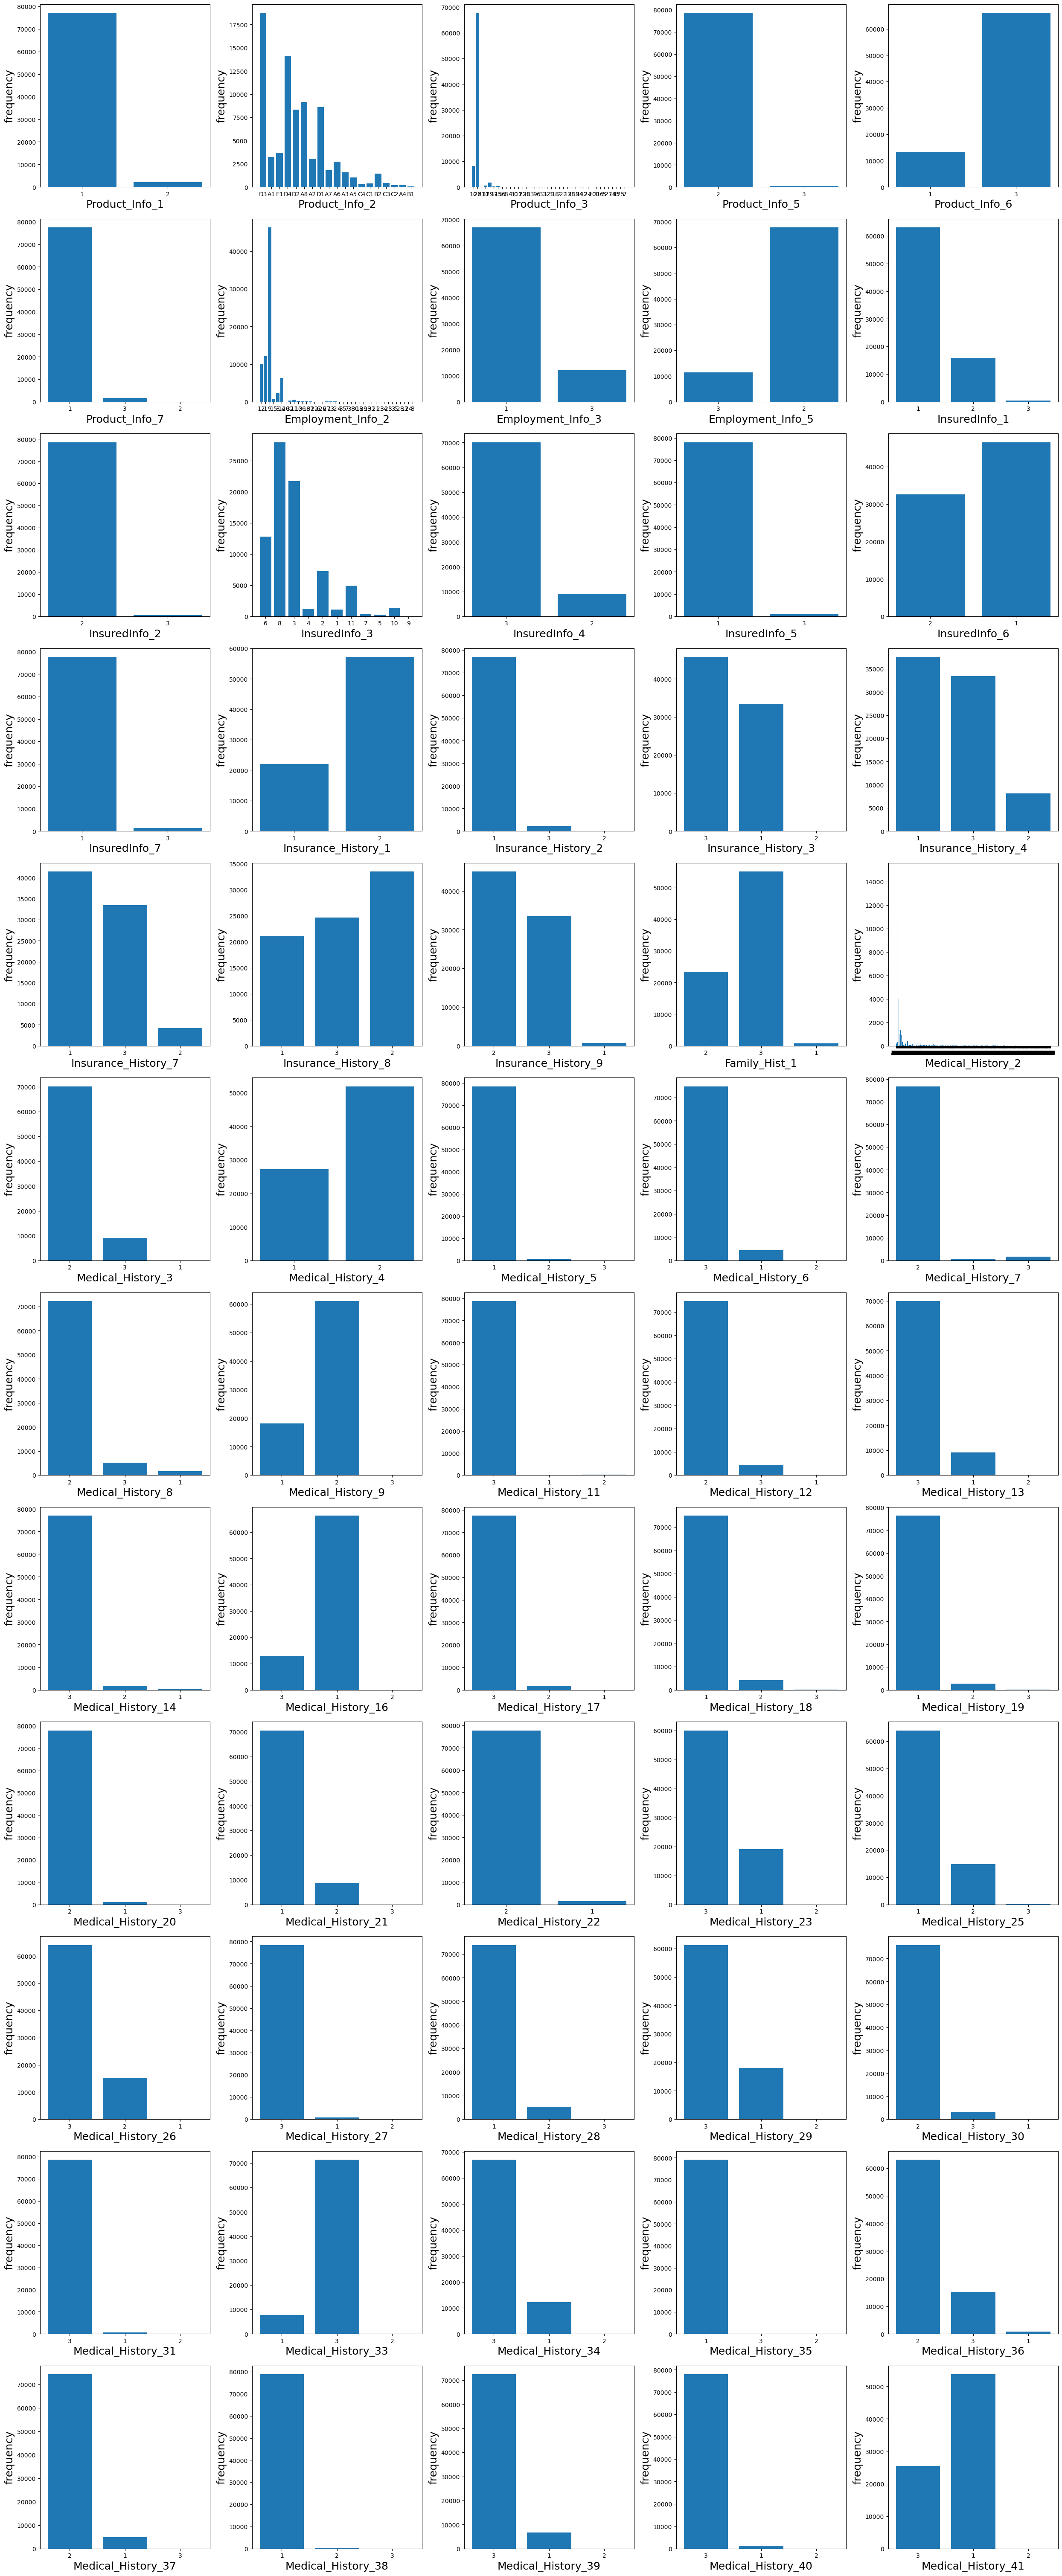

In [49]:
# display categorical data

def plot_categoricals(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        cnt = Counter(data[col])
        keys = list(cnt.keys())
        vals = list(cnt.values())
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.bar(range(len(keys)), vals, align="center")
        plt.xticks(range(len(keys)), keys)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_categoricals(categorical_data)

To handle the categorical data with scikit-learn functions, I transformed them into dummy data by 'pandas.get_dummies'.  
Noted that there are no missing values in categorical data.

In [50]:
categorical_data = categorical_data.applymap(str)  # need to conver into strings to appyly get_dummies
categorical_data = pd.get_dummies(categorical_data, drop_first=True)

### Continuous Data
---
The following 13 columns represent continuous data:

Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5

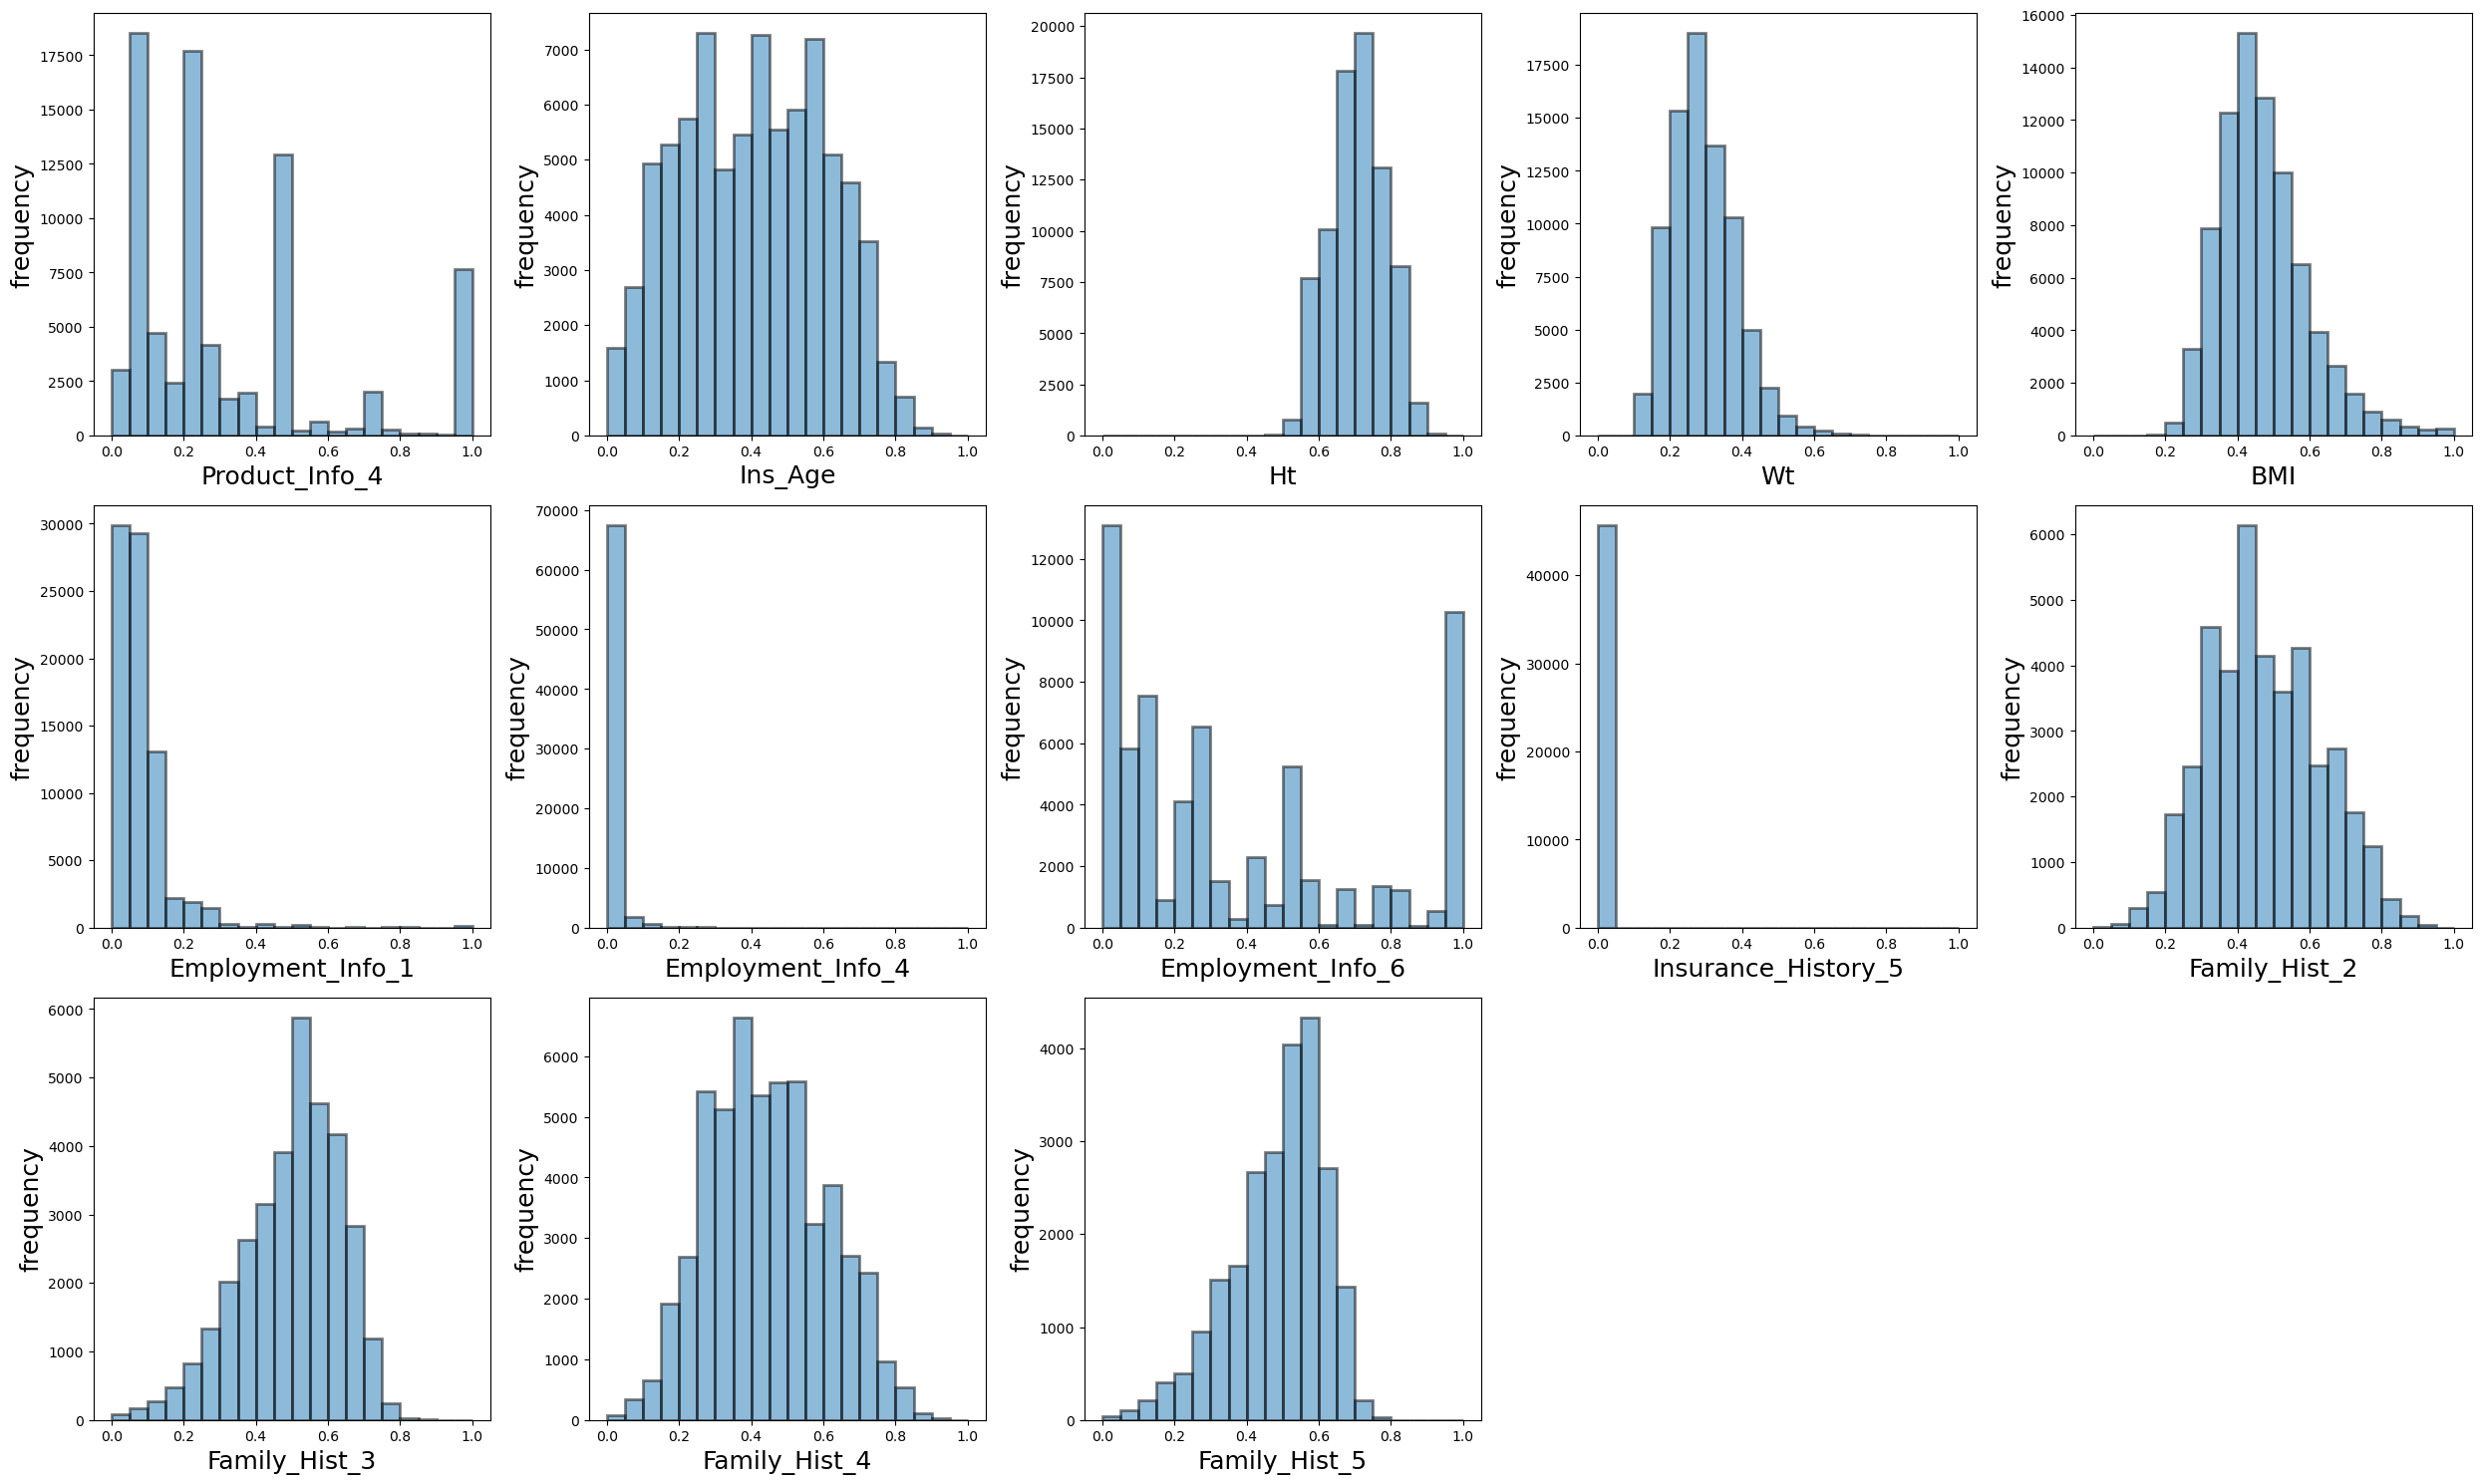

In [51]:
# display continuous data

def plot_histgrams(data):
    ncols = len(data.columns)
    fig = plt.figure(figsize=(5 * 5, 5 * (ncols // 5 + 1)))
    for i, col in enumerate(data.columns):
        X = data[col].dropna()
        plt.subplot(ncols // 5 + 1, 5, i + 1)
        plt.hist(X, bins=20, alpha=0.5, \
                 edgecolor="black", linewidth=2.0)
        plt.xlabel(col, fontsize=18)
        plt.ylabel("frequency", fontsize=18)
    fig.tight_layout()
    plt.show()

plot_histgrams(continuous_data)

Because some distributions are skewed, I applied the Box-Cox transformation on them.  
Furthermore, each column is normalized and every missing value is set to 0.

In [52]:
# apply the Box-Cox transformations on the continuous data

"""preprocessing quantitative variable"""
def preproc_quantitatives(X):
    Y = X.copy()

    # apply Box-Cox transformations on non-missing values
    not_missing = Y[~Y.isnull()].copy()
    not_missing = not_missing - np.min(not_missing) + 1e-10  # to avoid errors with non-positive values
    res = stats.boxcox(not_missing)
    Y[~Y.isnull()] = res[0]

    # normalize non-missing values
    mu = np.mean(Y[~Y.isnull()])
    sigma = Y[~Y.isnull()].std()
    Y = (Y - mu) / sigma

    # fill missing values with means
    Y[Y.isnull()] = 0.0

    return Y

# preprocessing continuous_data
for col in continuous_data.columns:
    continuous_data[col] = preproc_quantitatives(continuous_data[col])

The preprocessed version of continuous data are here.

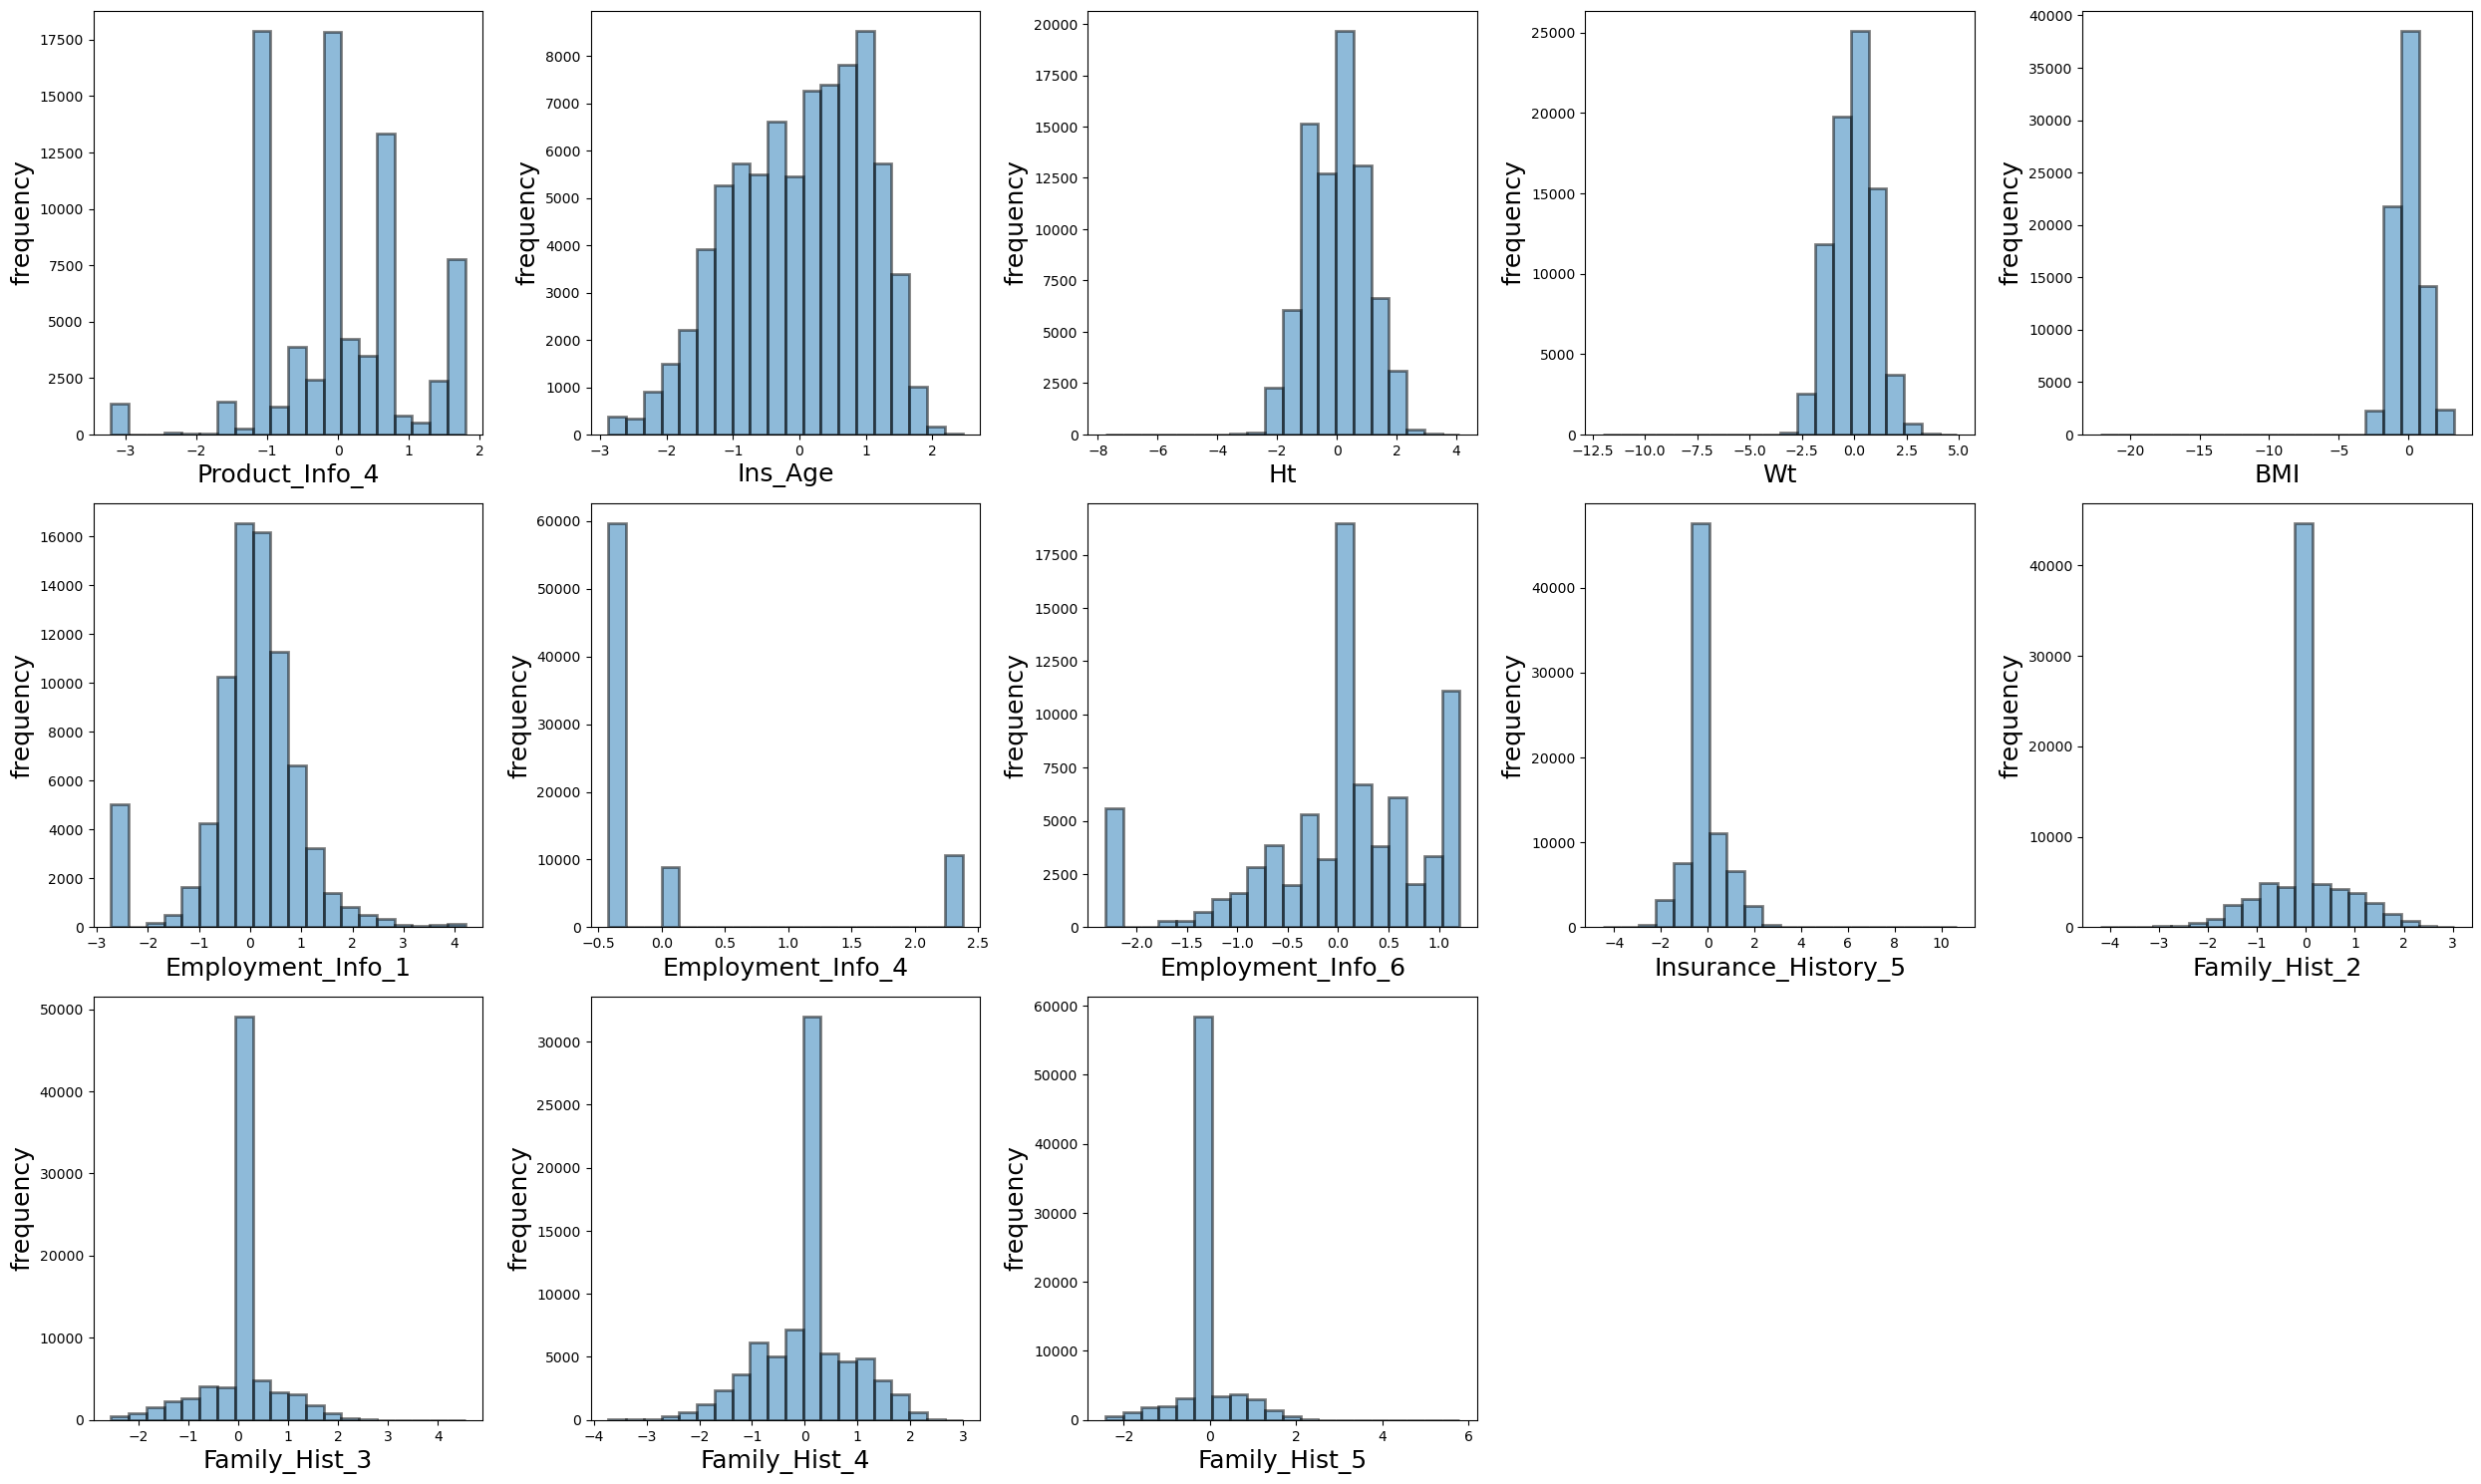

In [53]:
plot_histgrams(continuous_data)

### Discrete Data
---
The following 5 columns represent continuous data:

Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32  

I treated the discrete data with the same manner as the one for continuous data.

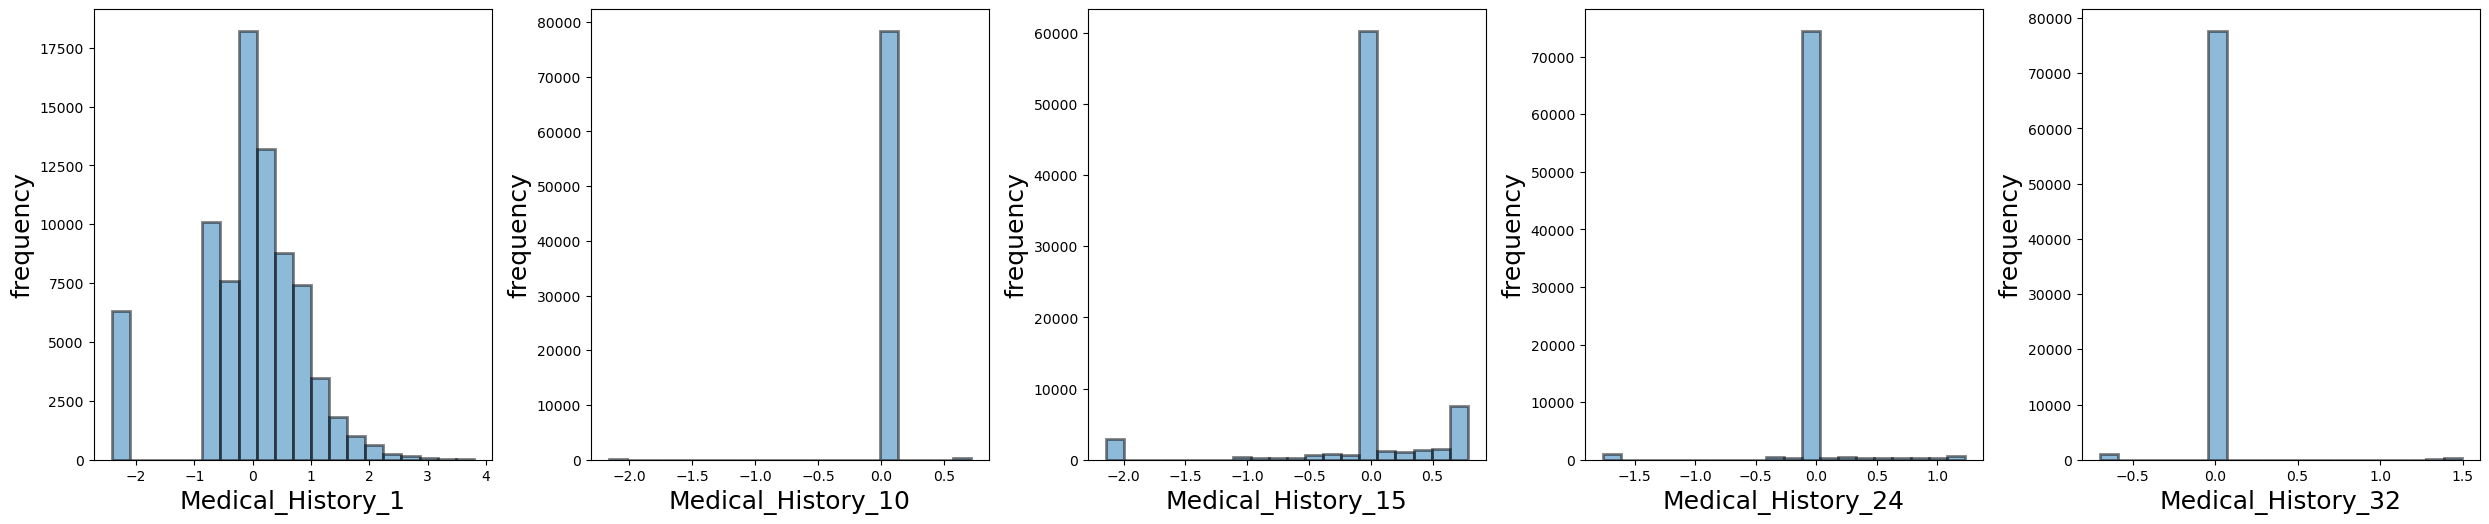

In [54]:
# preprocessing discrete data
for col in discrete_data.columns:
    discrete_data[col] = preproc_quantitatives(discrete_data[col])

# display the discrete data
plot_histgrams(discrete_data)

### Dummy Data
---
Medical_Keyword_1-48 are dummy variables.  
I didn't apply any preprocessing methods onto that.

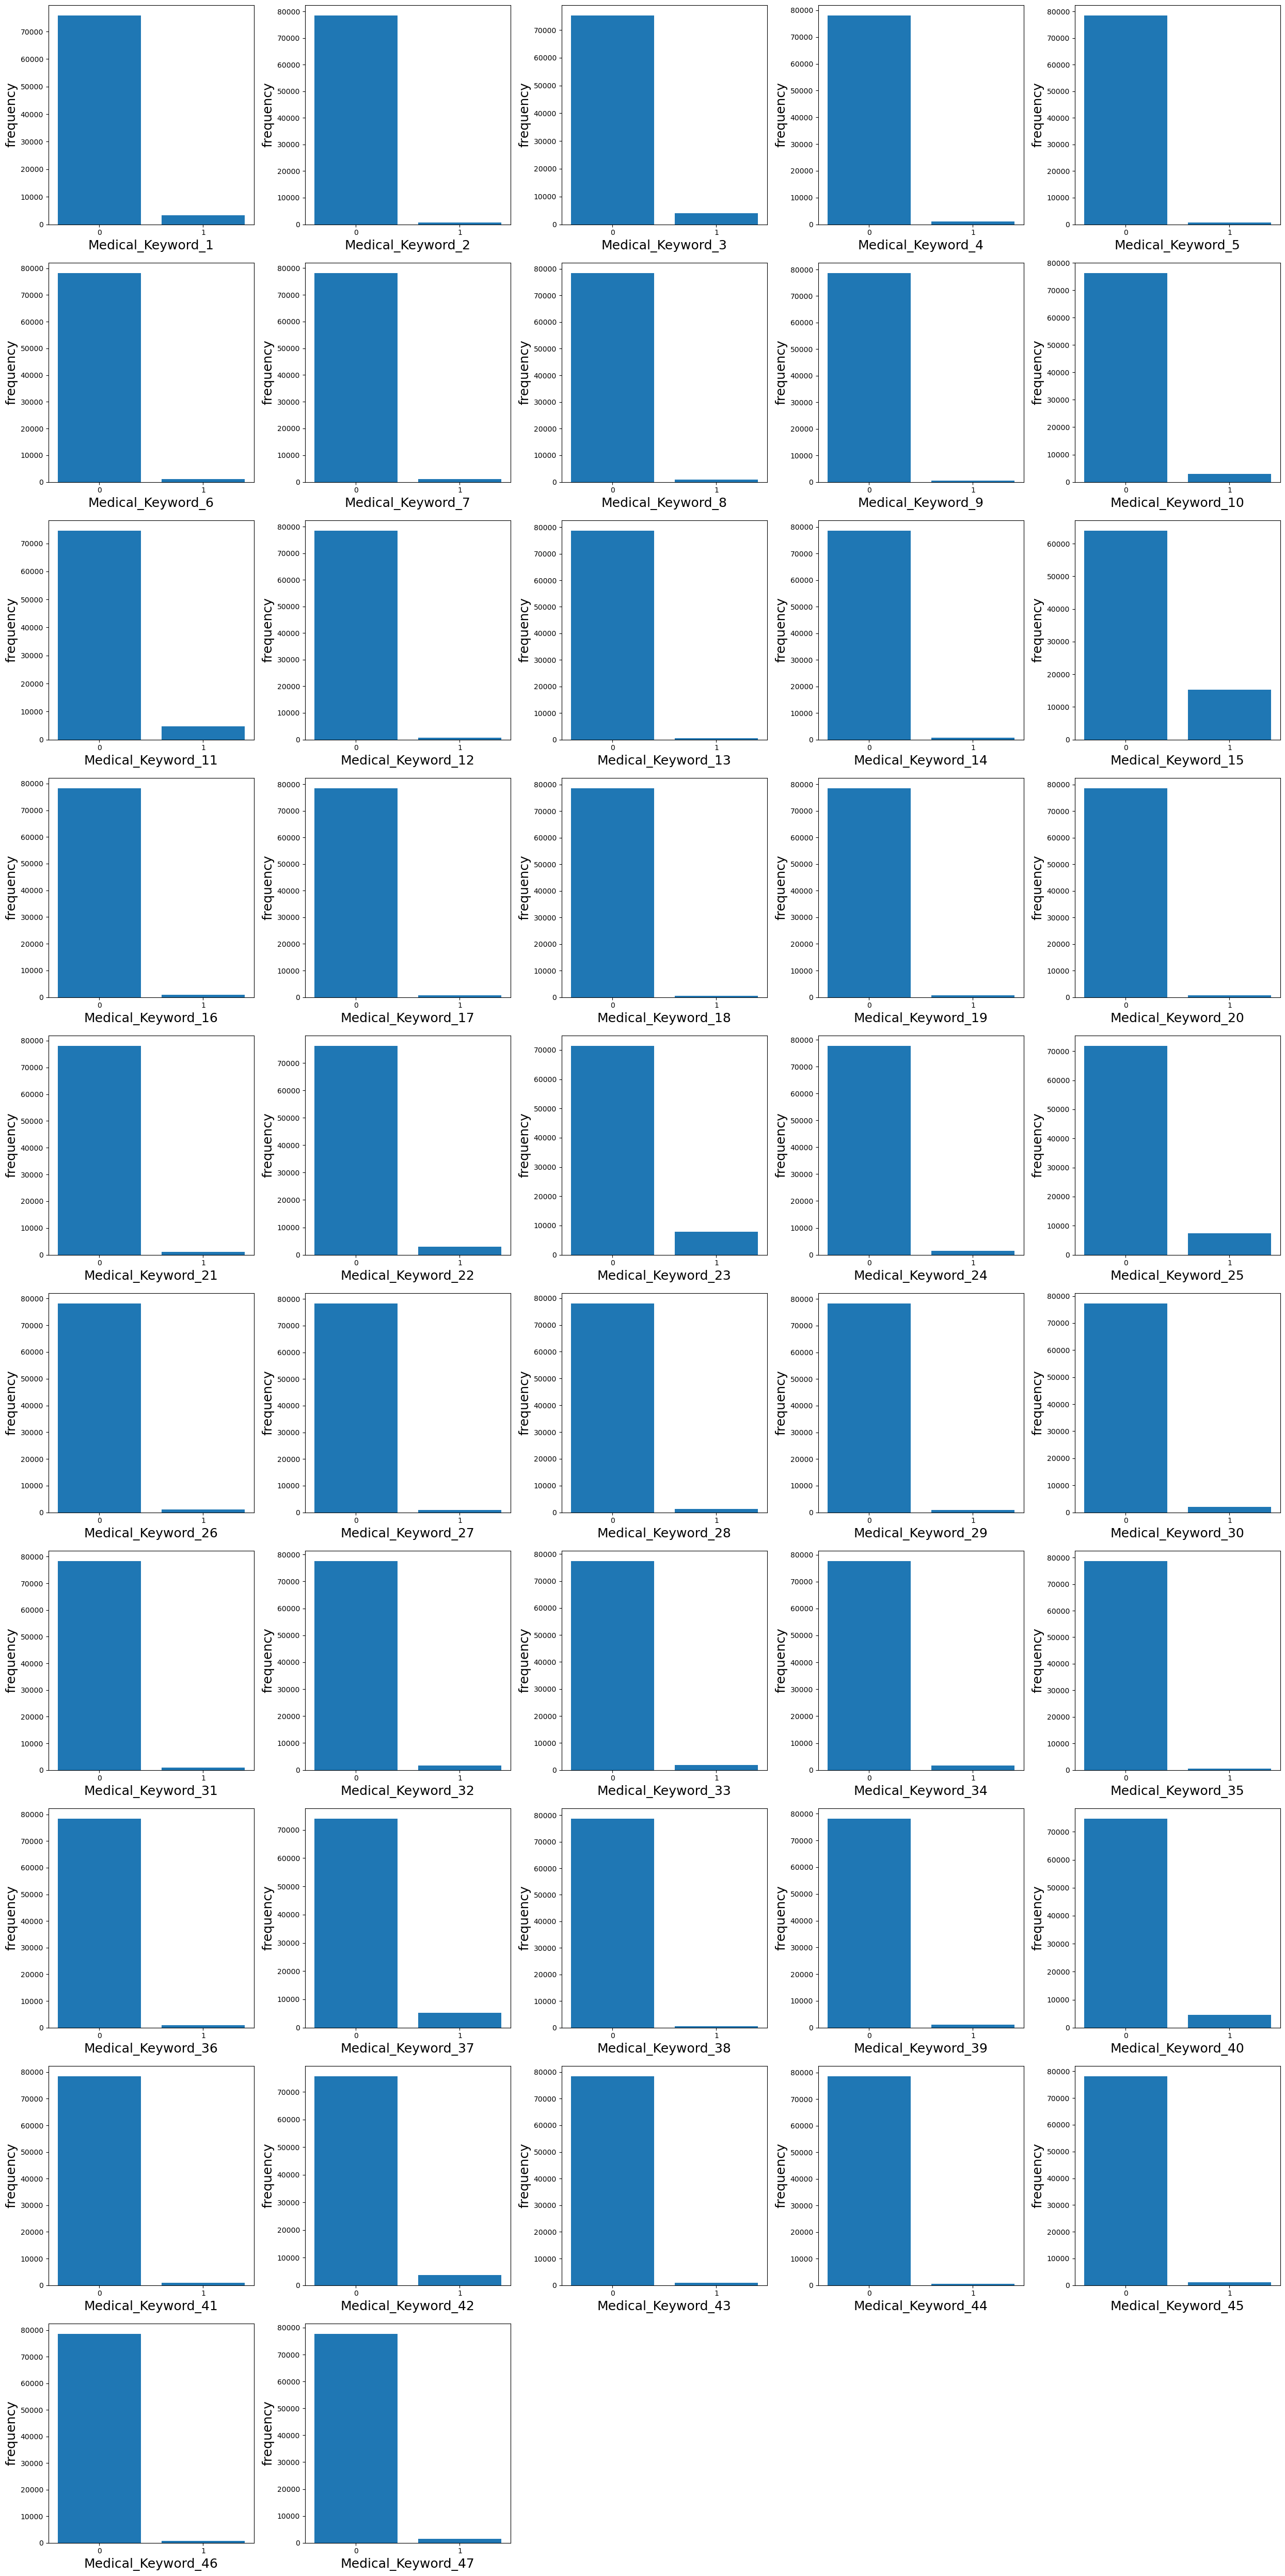

In [55]:
plot_categoricals(dummy_data)

## Constructing Prediction Model
---

I used ridge regression models to predict target variables.  
Before prediction, I made several experiments to judge whether all the columns should be used or not, and to determine the value of hyper-parameter alpha, using 40000 rows for train and 10000 rows for test, both retrieved from TRAIN_DATA.  


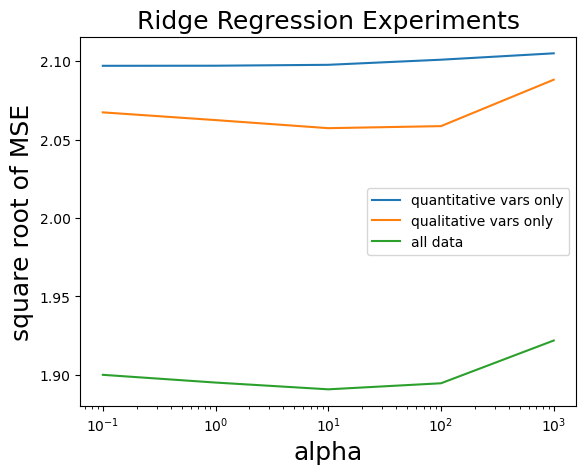

In [56]:
# Ridge Regression for various alpha

configs = {'quantitative vars only' : pd.concat([continuous_data, discrete_data], axis = 1),
           'qualitative vars only' : pd.concat([categorical_data, dummy_data], axis = 1),
           'all data' : pd.concat([continuous_data, discrete_data, categorical_data, dummy_data], axis = 1)}

errors_dict = {}

y = TRAIN_DATA['Response']
for title, X in configs.items():
    X_train = X[:40000]
    X_test = X[40000:50000]
    y_train = y[:40000]
    y_test = y[40000:50000]
    alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]
    errors = []

    for alpha in alphas:
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        z = model.predict(X_test)
        error = np.sqrt(np.sum((y_test - z) * (y_test - z)) / (1.0 * len(y_test)))
        errors.append(error)
    errors_dict[title] = errors

errors_dict = pd.DataFrame(data=errors_dict)


plt.plot(alphas, errors_dict)
plt.xlabel("alpha", fontsize=18)
plt.ylabel("square root of MSE", fontsize=18)
plt.title('Ridge Regression Experiments', fontsize=18)
plt.legend(errors_dict.columns)
plt.xscale('log')
plt.show()

From the above chart which shows square roots of mean squared errors (MSE) of several settings, I decided to use all the columns to predict the target variable, and set alpha = 10.0.

## Prediction
---

The following python code predicts target variables for the test data of the original problem, and generates a submission (csv) file.  

In [57]:
# predict for test data and generate submission

X = pd.concat([continuous_data, discrete_data, categorical_data, dummy_data], axis = 1)
X_train = X[:len(y)]
X_test = X[len(y):]

model = Ridge(alpha=10.0)
model.fit(X_train, y)
z = model.predict(X_test)

z = np.round(z)
z[z < 1] = 1
z[z > 8] = 8
z = z.astype(np.int64)

df = pd.DataFrame(data={'Id' : TEST_DATA['Id'], 'Response' : z})
df.to_csv('submit_ridge_1.csv', index=False)

In my running, it scores 0.55443, and I believe that it is apparently far from the top scores (near 0.7) but a nice startpoint for thinking about the problem.

https://www.kaggle.com/c/prudential-life-insurance-assessment

In [58]:
X_train['Ht']

0       -1.662560
1       -1.427467
2        0.510382
3       -0.470781
4       -0.712328
           ...   
59376    0.016865
59377    1.261188
59378    0.510382
59379   -0.227707
59380    1.009550
Name: Ht, Length: 59381, dtype: float64

Adding onto his original markdowns and code

In [59]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Assuming demographics data contains columns like 'age', 'gender', 'income'
demographics_train = X_train[:len(y)]

age_subpopulations = [
    (-2.876335, -0.779044, 'young_adults'),
    (-0.779043,  0.808313, 'middle_aged'),
    ( 0.808314, np.inf, 'seniors'),
]
subpopulation_indices = {}

for lower, upper, name in age_subpopulations:
    indices = demographics_train[(demographics_train['Ins_Age'] >= lower) & (demographics_train['Ins_Age'] <= upper)].index
    subpopulation_indices[name] = indices

In [60]:
rmse_normalized_subpopulations = {}

for name, indices in subpopulation_indices.items():
    y_true = y.iloc[indices]
    y_pred = model.predict(X_train.iloc[indices])
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_normalized_subpopulations[name] = rmse

print("RMSE for different normalized age subpopulations:", rmse_normalized_subpopulations)

class_distribution_normalized_subpopulations = {}

for name, indices in subpopulation_indices.items():
    class_distribution = y.iloc[indices].value_counts(normalize=True)
    class_distribution_normalized_subpopulations[name] = class_distribution

print("Class distribution for different normalized age subpopulations:", class_distribution_normalized_subpopulations)


RMSE for different normalized age subpopulations: {'young_adults': 1.6758336673723295, 'middle_aged': 1.8275253188033902, 'seniors': 2.226133334740651}
Class distribution for different normalized age subpopulations: {'young_adults': 8    0.465627
6    0.155607
7    0.102721
5    0.088520
2    0.073988
1    0.058726
4    0.033179
3    0.021632
Name: Response, dtype: float64, 'middle_aged': 8    0.321466
6    0.201310
7    0.143209
2    0.108299
5    0.091520
1    0.090411
4    0.026139
3    0.017645
Name: Response, dtype: float64, 'seniors': 6    0.201872
8    0.196067
1    0.181772
2    0.153472
7    0.153037
5    0.092374
3    0.011102
4    0.010304
Name: Response, dtype: float64}


In [61]:
X_train['Ht'].describe()

count    59381.000000
mean         0.004814
std          0.999147
min         -7.740521
25%         -0.712328
50%          0.016865
75%          0.759273
max          4.112879
Name: Ht, dtype: float64

In [62]:
X_train['Wt'].describe()

count    59381.000000
mean         0.000561
std          0.998318
min        -12.000578
25%         -0.711507
50%          0.066754
75%          0.667608
max          4.914752
Name: Wt, dtype: float64

In [63]:
X_train['BMI'].describe()

count    59381.000000
mean        -0.002359
std          0.999462
min        -22.133492
25%         -0.663715
50%         -0.052527
75%          0.609474
max          3.301136
Name: BMI, dtype: float64

In [64]:
# Assuming demographics data contains a column like 'height'
demographics_train = X_train[:len(y)]

# Example: create height-based subpopulations (short, medium, tall)
height_subpopulations = [
    (-7.740521, -0.712328, 'short'),
    (-0.712327, 0.759273, 'medium'),
    (0.759274, np.inf, 'tall'),
]

height_subpopulation_indices = {}

for lower, upper, name in height_subpopulations:
    indices = demographics_train[(demographics_train['Ht'] >= lower) & (demographics_train['Ht'] <= upper)].index
    height_subpopulation_indices[name] = indices
rmse_height_subpopulations = {}

for name, indices in height_subpopulation_indices.items():
    y_true = y.iloc[indices]
    y_pred = model.predict(X_train.iloc[indices])
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_height_subpopulations[name] = rmse

print("RMSE for different height subpopulations:", rmse_height_subpopulations)

class_distribution_height_subpopulations = {}

for name, indices in height_subpopulation_indices.items():
    class_distribution = y.iloc[indices].value_counts(normalize=True)
    class_distribution_height_subpopulations[name] = class_distribution

print("Class distribution for different height subpopulations:", class_distribution_height_subpopulations)


RMSE for different height subpopulations: {'short': 1.8751740134917594, 'medium': 1.8997109543705675, 'tall': 1.921404287870942}
Class distribution for different height subpopulations: {'short': 8    0.423144
6    0.136305
7    0.122436
2    0.096359
5    0.094409
1    0.089353
4    0.023620
3    0.014374
Name: Response, dtype: float64, 'medium': 8    0.313247
6    0.197898
7    0.139384
1    0.109802
2    0.109700
5    0.088506
4    0.024378
3    0.017085
Name: Response, dtype: float64, 'tall': 8    0.239127
6    0.238490
7    0.141389
2    0.131432
1    0.113032
5    0.093914
4    0.023180
3    0.019436
Name: Response, dtype: float64}


In [65]:
# Assuming demographics data contains a column like 'weight'
demographics_train = X_train[:len(y)]

# Example: create weight-based subpopulations (underweight, normal_weight, overweight)
weight_subpopulations = [
    (-12.000578, -0.711507, 'underweight'),
    (-0.711506, 0.667608, 'normal_weight'),
    (0.667609, np.inf, 'overweight'),
]

weight_subpopulation_indices = {}

for lower, upper, name in weight_subpopulations:
    indices = demographics_train[(demographics_train['Wt'] >= lower) & (demographics_train['Wt'] <= upper)].index
    weight_subpopulation_indices[name] = indices
rmse_weight_subpopulations = {}

for name, indices in weight_subpopulation_indices.items():
    y_true = y.iloc[indices]
    y_pred = model.predict(X_train.iloc[indices])
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_weight_subpopulations[name] = rmse

print("RMSE for different weight subpopulations:", rmse_weight_subpopulations)

class_distribution_weight_subpopulations = {}

for name, indices in weight_subpopulation_indices.items():
    class_distribution = y.iloc[indices].value_counts(normalize=True)
    class_distribution_weight_subpopulations[name] = class_distribution

print("Class distribution for different weight subpopulations:", class_distribution_weight_subpopulations)


RMSE for different weight subpopulations: {'underweight': 1.8613132056754484, 'normal_weight': 1.9312315322674014, 'overweight': 1.869277274559693}
Class distribution for different weight subpopulations: {'underweight': 8    0.593045
6    0.097638
7    0.095801
1    0.071260
2    0.059908
5    0.039633
4    0.033071
3    0.009646
Name: Response, dtype: float64, 'normal_weight': 8    0.325355
6    0.205960
7    0.165320
1    0.100985
2    0.093621
5    0.066108
4    0.026525
3    0.016126
Name: Response, dtype: float64, 'overweight': 6    0.250118
2    0.195354
5    0.195084
1    0.145790
7    0.116011
8    0.061247
3    0.026538
4    0.009859
Name: Response, dtype: float64}


In [66]:
# Assuming demographics data contains columns like 'weight' and 'height'
demographics_train = X_train[:len(y)]

# Example: create BMI-based subpopulations (underweight, normal, overweight, obese)
bmi_subpopulations = [
    (-22.133492, -0.663715, 'underweight'),
    (-0.663714, -0.052527, 'normal'),
    (-0.052526, 0.609474, 'overweight'),
    (0.609475, np.inf, 'obese'),
]

bmi_subpopulation_indices = {}

for lower, upper, name in bmi_subpopulations:
    indices = demographics_train[(demographics_train['BMI'] >= lower) & (demographics_train['BMI'] <= upper)].index
    bmi_subpopulation_indices[name] = indices


In [67]:
rmse_bmi_subpopulations = {}

for name, indices in bmi_subpopulation_indices.items():
    y_true = y.iloc[indices]
    y_pred = model.predict(X_train.iloc[indices])
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_bmi_subpopulations[name] = rmse

print("RMSE for different BMI subpopulations:", rmse_bmi_subpopulations)

class_distribution_bmi_subpopulations = {}

for name, indices in bmi_subpopulation_indices.items():
    class_distribution = y.iloc[indices].value_counts(normalize=True)
    class_distribution_bmi_subpopulations[name] = class_distribution

print("Class distribution for different BMI subpopulations:", class_distribution_bmi_subpopulations)


RMSE for different BMI subpopulations: {'underweight': 1.8737051599693013, 'normal': 1.9269131332198774, 'overweight': 1.9723436858835086, 'obese': 1.81600398514218}
Class distribution for different BMI subpopulations: {'underweight': 8    0.591530
6    0.108800
7    0.089073
1    0.077156
2    0.056083
4    0.033663
5    0.033327
3    0.010368
Name: Response, dtype: float64, 'normal': 8    0.440901
6    0.169105
7    0.136269
1    0.086508
2    0.084755
5    0.040726
4    0.029330
3    0.012406
Name: Response, dtype: float64, 'overweight': 8    0.261165
6    0.215093
7    0.213680
1    0.106134
2    0.104318
5    0.057977
4    0.027374
3    0.014259
Name: Response, dtype: float64, 'obese': 6    0.263925
5    0.234285
2    0.196408
1    0.148403
7    0.101344
3    0.031261
8    0.018567
4    0.005806
Name: Response, dtype: float64}


In [68]:
from sklearn.metrics import confusion_matrix

def demographic_parity(y_true, y_pred, subpopulations):
    parity_results = {}
    overall_positive_rate = np.mean(y_pred)
    
    for group in subpopulations:
        group_indices = subpopulations[group]
        group_predictions = y_pred[group_indices]
        group_positive_rate = np.mean(group_predictions)
        
        parity_results[group] = abs(group_positive_rate - overall_positive_rate)
    
    return parity_results


In [69]:
# Get the predicted outcomes using the trained model
y_pred = model.predict(X_train)
y_pred_rounded = np.round(y_pred).astype(np.int64)


In [70]:
age_demographic_parity = demographic_parity(y, y_pred_rounded, subpopulation_indices)
height_demographic_parity = demographic_parity(y, y_pred_rounded, height_subpopulation_indices)
weight_demographic_parity = demographic_parity(y, y_pred_rounded, weight_subpopulation_indices)
bmi_demographic_parity = demographic_parity(y, y_pred_rounded, bmi_subpopulation_indices)

In [71]:
print("Age demographic parity:", age_demographic_parity)
print("Height demographic parity:", height_demographic_parity)
print("Weight demographic parity:", weight_demographic_parity)
print("BMI demographic parity:", bmi_demographic_parity)

Age demographic parity: {'young_adults': 0.5794087111954269, 'middle_aged': 0.0789534505501619, 'seniors': 0.7811034227077132}
Height demographic parity: {'short': 0.3640163315712641, 'medium': 0.09202241326185678, 'tall': 0.25569506187187585}
Weight demographic parity: {'underweight': 1.0216069305288267, 'normal_weight': 0.015554648363576007, 'overweight': 1.081969435301061}
BMI demographic parity: {'underweight': 1.0746689726624714, 'normal': 0.3548032123114515, 'overweight': 0.21344541462294409, 'obese': 1.2189697290830708}
